# Logarithmic Magnitude Resolution
The human ear has a wide range of sound pressure, which can be analysed. From the hearing threshold to the threshold of pain it is more than $100$ dB which corresponds to a factor of $10^{100/20}=100000$ in the amplitudes.

The reasons for applying the logarithm to audio feature befor analysis/classification are:

Firstly, the human ear recognises loudness or signal energy in a logarithmic way. This is one of the motivations for the dB SPL scale.

Secondly, the compression of the logarithm makes all analysis software more robust, generally.

In the following, an audio signal is processed by the DFT and a spectral smoothing by the Mel filterbank. After that, the effects of applying a logarithm is shown.

## Input signal and DFT
Firstly, the input signal is converted in a spectrum by the DFT:

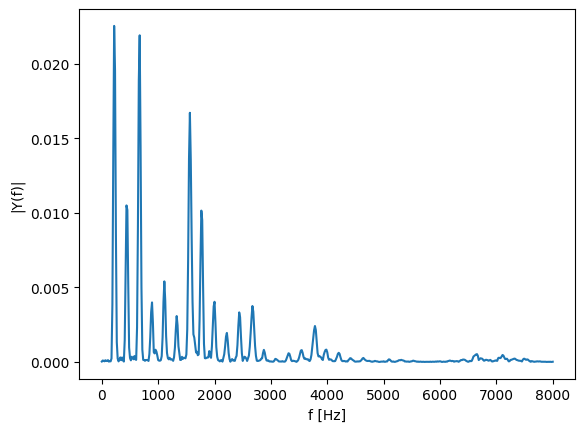

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../Python')
import WaveInterface

y, Fs, bits = WaveInterface.ReadWave('../Audio/SevenEnglishFemale.wav')

HopsizeInMilliseconds = 10
hs = int(HopsizeInMilliseconds * Fs / 1000)
ws = 4*hs
w = np.hamming(ws)
FFTLen = int(2**np.ceil(np.log2(ws)))

col = 45
idx1 = col * hs
idx2 = idx1 + ws
y_block = y[idx1:idx2] * w
Y = np.abs(np.fft.rfft(y_block, n = FFTLen)) / FFTLen

Delta_T = 1/Fs
Delta_f = 1/(Delta_T * FFTLen)
f = np.arange(Y.shape[0])*Delta_f
plt.plot(f, Y)
plt.ylabel('|Y(f)|')
plt.xlabel('f [Hz]')
plt.show()

## Mel Filterbank

As explained earlier, the mel filterbank applies a logarithmic frequency resolution. This is usually combined with a strong smoothing of the spectrum, i.e. the envelope of the spectrum is evaluated with the mel filterbank.

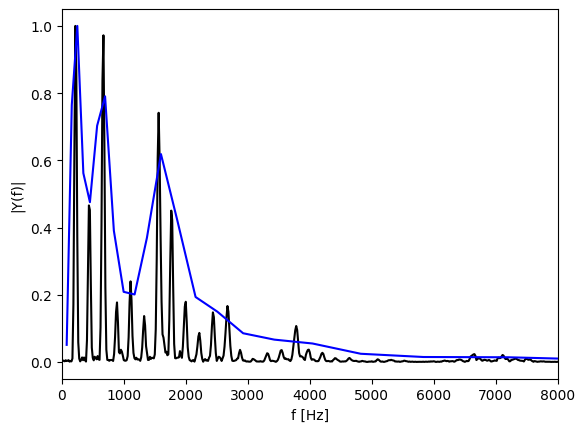

In [2]:
def Bark2KiloHertz(b):
    return 1.96 * (b + 0.53) / (26.28 - b)

CutoffFrequenciesInBark = np.arange(25)
CutoffFrequenciesInHertz = Bark2KiloHertz(CutoffFrequenciesInBark) * 1000
CenterFrequenciesInHertz = np.diff(CutoffFrequenciesInHertz) / 2
CenterFrequenciesInHertz += CutoffFrequenciesInHertz[0:CutoffFrequenciesInHertz.shape[0]-1]

T_Hertz2Bark = np.zeros((CenterFrequenciesInHertz.shape[0], Y.shape[0]))
for b in range(T_Hertz2Bark.shape[0]):
    m1 = (1 - 1/np.sqrt(2)) / (CenterFrequenciesInHertz[b] - CutoffFrequenciesInHertz[b]) # first derivative of first line
    m2 = (1 - 1/np.sqrt(2)) / (CenterFrequenciesInHertz[b] - CutoffFrequenciesInHertz[b+1]) # first derivative of second line
    assert m1 > 0, 'm1 must be greater 0'
    assert m2 < 0, 'm2 must be smaller 0'
    b1 = 1 - m1 * CenterFrequenciesInHertz[b] # offset of first line
    b2 = 1 - m2 * CenterFrequenciesInHertz[b] # offset of second line
    assert b1 < 1/np.sqrt(2), 'b1 must be smaller than 1/sqrt(2)'
    assert b2 > 0, 'b2 must be greater 0'
    v1 = m1 * f + b1
    v2 = m2 * f + b2
    v3 = np.minimum(v1, v2)
    v4 = np.maximum(v3, 0.0)
    f1 = -b1 / m1 # zero crossing of the first line
    f2 = -b2 / m2 # zero crossing of the second line
    T_Hertz2Bark[b, :] = v4 / (0.5*(f2 - f1))

Y_mel = np.matmul(T_Hertz2Bark, Y)
plt.plot(f, Y / np.amax(Y), 'k')
plt.plot(CenterFrequenciesInHertz, Y_mel / np.amax(Y_mel), 'b')
plt.ylabel('|Y(f)|')
plt.xlabel('f [Hz]')
plt.xlim([0, 8000])
plt.show()

## Logarithm
Generally, all sensors are noisy. Therefore, all signal processing algorithms must be capable of dealing with noise.

In the following, two signals are processed. The raw signal $y$ and the noisy variant $y_\text{noisy}$. The SNR is evaluated for each signal processing step:

Before DFT,

after DFT,

after applying the Mel filterbank and finally

after applying the logarithm.

Obvisouly, increasing the NoiseGain decreases the SNR for all signal processing steps.

In [3]:
NoiseGain = 0.1
y_noisy = y_block + np.random.randn(y_block.shape[0]) * NoiseGain
SNR = 10*np.log10(np.sum(y_block**2) / np.sum((y_noisy - y_block)**2))
print('SNR (time domain) = ', SNR, ' dB')

Y_noisy = np.abs(np.fft.rfft(y_noisy, n = FFTLen)) / FFTLen
SNR = 10*np.log10(np.sum(Y**2) / np.sum((Y_noisy - Y)**2))
print('SNR (frequency domain) = ', SNR, ' dB')

Y_mel_noisy = np.matmul(T_Hertz2Bark, Y_noisy)
SNR = 10*np.log10(np.sum(Y_mel**2) / np.sum((Y_mel_noisy - Y_mel)**2))
print('SNR (mel domain) = ', SNR, ' dB')

Y_log = np.log(Y_mel)
Y_log_noisy = np.log(Y_mel_noisy)
SNR = 10*np.log10(np.sum(Y_log**2) / np.sum((Y_log_noisy - Y_log)**2))
print('SNR (log domain) = ', SNR, ' dB')

SNR (time domain) =  1.2101980192951916  dB
SNR (frequency domain) =  1.8939624464823543  dB
SNR (mel domain) =  3.6260073991311526  dB
SNR (log domain) =  15.506977905899792  dB


## Sensitivity and noise robustness
One problem of applying the logarithm to noisy recordings is the sensitivity of the logarithm for small input values $0<x<1$. Regarding the lesson Metrology, the sensitivity of a noisy process can be defined by the derivative:

Sensitivity $=\frac{d\log\left(x\right)}{dx}=\frac{1}{x}$

Unfortunately, the sensitivity for small values of $x$ goes to infinity. This means, that small amounts of noise has an arbitrary large impact on the following signal processing steps.

One workaround for this problem is the following replacement of the logarithm by the following mapping with a factor $a>0$:

$\log\left(a\cdot x+1\right)$  with the corresponding sensitivity:

$\frac{d\log\left(a\cdot x+1\right)}{dx}=\frac{a}{a\cdot x+1}$ which is limited to the range $0...a$.

In [4]:
gain = 1e13
Y_log = np.log(gain*Y_mel+1)
Y_log_noisy = np.log(gain*Y_mel_noisy+1)
SNR = 10*np.log10(np.sum(Y_log**2) / np.sum((Y_log_noisy - Y_log)**2))
print('SNR (log domain) = ', SNR, ' dB')

SNR (log domain) =  21.082226308119306  dB


It can be seen, that the suggested mapping decreases the influence of the noise in the logarithmic domain.

## Programming exercise:

1) In order to estimate the sensitivity, the gradient of an arbitrary function must be known.

    The gradient of a function $f(x)$ at the position $x=x_0$ is usually derived by

    $\frac{df}{dx}=\frac{f(x_0+h)-f(x_0-h)}{2\cdot h}$ for $h\rightarrow 0$.

    Write a procedure EstimateGradient, which works with small values of $h$ in order to pass the given tests.

2) The mapping $y=\log\left(a\cdot x+1\right)$ ensures $y\geq 0$. Implement an additional scaling factor $b$, such that $0\leq y \leq 1$ for $0\leq x \leq 1$: $y=b\cdot\log\left(a\cdot x+1\right)$

In [6]:
def EstimateGradient(x, FunctionPointer):
    # solution begins
    h = 1e-10
    y1 = FunctionPointer(x+h)
    y2 = FunctionPointer(x-h)
    grad = (y1 - y2) / (2*h)
    # solution ends
    return grad

def LogarithmicMapping(x, a = 1e4):
    assert np.amax(x) <= 1.0, 'input values too large'
    assert np.amin(x) >= 0.0, 'input values too small'
    b = 1/np.log(a+1) # solution
    return b*np.log(a*x+1)

import unittest

def PearsonsCrossCorrelation(x, y):
    x_mean0 = x - np.mean(x)
    y_mean0 = y - np.mean(y)
    return np.sum(x_mean0 * y_mean0)/np.sqrt(np.sum(x_mean0**2) * np.sum(y_mean0**2))

def PearsonsRankCorrelation(x, y):
    x_rank = np.argsort(x)
    y_rank = np.argsort(y)
    return PearsonsCrossCorrelation(x_rank, y_rank)

class TestProgrammingExercise(unittest.TestCase):

    def test_grad1(self):
        a = np.random.randn(1)
        b = np.random.randn(1)
        
        def LinearFunction(x):
            return a*x+b

        for n in range(10):
            x = np.random.randn(1)
            self.assertAlmostEqual(EstimateGradient(x, LinearFunction), a, delta = 1e-3)
    
    def test_grad2(self):
        a = np.random.randn(1)
        b = np.random.randn(1)
        c = np.random.randn(1)
        
        def Parabel(x):
            return a*x*x+b*x+c

        for n in range(10):
            x = np.random.randn(1)
            self.assertAlmostEqual(EstimateGradient(x, Parabel), 2*a*x+b, delta = 1e-3)

    def test_grad3(self):
        a = 1000
        def LogarithmWithOffset(x):
            return np.log(a*x+1)

        for n in range(10):
            x = np.random.rand(1)*1000
            self.assertAlmostEqual(EstimateGradient(x, LogarithmWithOffset), a / (a*x+1), delta = 1e-3)

    def test_LogarithmicMappingRankOrder(self):
        x = np.random.rand(10000)
        y = LogarithmicMapping(x, np.random.rand(1)*1000)
        self.assertAlmostEqual(PearsonsRankCorrelation(x, y), 1.0, delta = 1e-3)

    def test_LogarithmicMappingOutputRange(self):
        x = np.random.rand(10)
        y = LogarithmicMapping(x, np.random.rand(1)*1000)
        self.assertGreaterEqual(np.amin(y), 0.0)
        self.assertLessEqual(np.amax(y), 1.0) 

    def test_LogarithmicMappingMaximum(self):
        x = 1.0
        y = LogarithmicMapping(x, np.random.rand(1)*1000)
        self.assertGreaterEqual(y[0], 1.0)

    def test_LogarithmicMappingMinimum(self):
        x = 0.0
        y = LogarithmicMapping(x, np.random.rand(1)*1000)
        self.assertGreaterEqual(y[0], 0.0)
        
unittest.main(argv=[''], verbosity=2, exit=False)

test_LogarithmicMappingMaximum (__main__.TestProgrammingExercise.test_LogarithmicMappingMaximum) ... ok
test_LogarithmicMappingMinimum (__main__.TestProgrammingExercise.test_LogarithmicMappingMinimum) ... ok
test_LogarithmicMappingOutputRange (__main__.TestProgrammingExercise.test_LogarithmicMappingOutputRange) ... ok
test_LogarithmicMappingRankOrder (__main__.TestProgrammingExercise.test_LogarithmicMappingRankOrder) ... ok
test_grad1 (__main__.TestProgrammingExercise.test_grad1) ... ok
test_grad2 (__main__.TestProgrammingExercise.test_grad2) ... ok
test_grad3 (__main__.TestProgrammingExercise.test_grad3) ... ok

----------------------------------------------------------------------
Ran 7 tests in 0.017s

OK


## Exam preparation:
 1) Assuming an input range of $0\leq x\leq 1$. Sketch $y=\log\left(100\cdot x+1\right)$.
 
 2) Evaluate the sensitivity of $y=\log\left(100\cdot x+1\right)$ regarding the input $x$.
 
 3) Evaluate the sensitivity of $y=\frac{3x}{2x^2+7x+1}$ regarding the input $x=2$.